In [1]:
# import libraries & setup plotting constants

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
pltC = ('red', 'blue', 'green', 'purple')
pltM = ('o', 'x', '*', '.', '+')

In [2]:
class PolyCalc(object):
    """ Return values of Polynomial """

    def __init__(self):                            
        """ """
        return None
    
    def values(self, coefs, x):
        """ returns y values for given x values       
        
        Parameters
        ----------
            coefs : {array-like}, shape = [deg+1]   
            x     : {array-like}, shape = [npts]
            
        """        
        deg1 = len(coefs)
        deg = deg1 - 1
        npts = len(x)        
        polyval = np.zeros(npts)
        for j in range(0, npts):
            polyval[j] = coefs[0]
            for k in range(1, deg1):
                polyval[j] +=  coefs[k] * x[j]**k  
        return (polyval)


In [3]:
# now prepare to generate a sample generated by a polynomial with random noise.

In [4]:
# set up the polynomial

ncoefs = 4
coefs = np.zeros(ncoefs)
coefs[0] = -6.0
coefs[1] = 7.0
coefs[2] = 6.0
coefs[3] = -9.0

xpoly = np.linspace(-1.0, 1.0,50)
PC = PolyCalc()
ypoly = PC.values(coefs,xpoly)

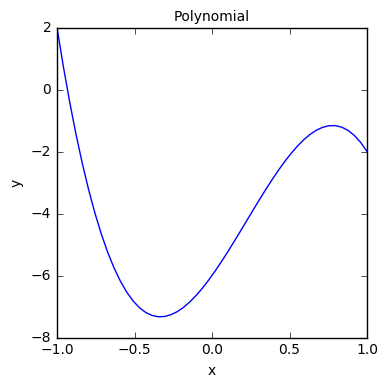

In [5]:
# plot polyn

plt.close('all')
plt.figure(figsize=(4,4))
plt.title('Polynomial', fontsize='medium')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(xpoly,ypoly, color = pltC[1])
plt.axis(range=1, aspect=1)
plt.show()

In [6]:
# prepare to normalize polynomial and add random noise 

s_tilda = 1.0
n_tilda = 1.0
g = 2.0 /(s_tilda + 2* n_tilda)
s = g * s_tilda
n = g * n_tilda

ymin = ypoly.min()
ymax = ypoly.max()

tr_ = (ymax - ymin)/s
if (tr_ < 0.0001): 
    t = 1000.0
else:
    t = 1/tr_

ypolyt = -1 +(ypoly - ymin)*t + n

cf = np.zeros(4)
cf[0] = -1 +(coefs[0] - ymin)*t + n
for i in range(1,4):
    cf[i] = coefs[i]*t

ypolycheck = PC.values(cf,xpoly)- ypolyt
print('maximum error - should be a very small number: ',np.sqrt((ypolycheck**2).max()))

maximum error - should be a very small number:  2.22044604925e-16


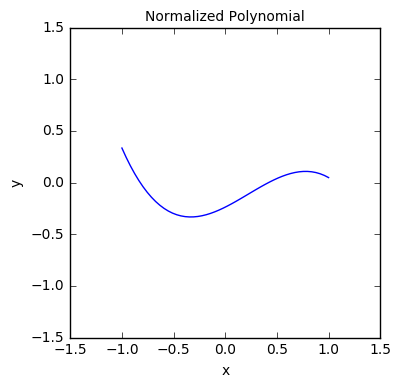

In [7]:
# plot poly

plt.close('all')
plt.figure(figsize=(4,4))
plt.title('Normalized Polynomial', fontsize='medium')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(xpoly,ypolyt, color = pltC[1])
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
#plt.axis(range=1, aspect=1)
plt.show()

In [8]:
# generate a sample from a polynomial with random noise.

npts = 250
sigma = 0.20
x = np.random.uniform(-1.0, 1.0,size = npts)
yrandom = np.random.normal(0.0, sigma, size = npts)

#limit yrandom to range [-1, +1]
for i in range(0,npts):
    if (yrandom[i] > 1.0):
        yrandom[i] = 1.0
    elif (yrandom[i] < -1.0):
        yrandom[i] = -1.0       

y = -1 + (PC.values(coefs,x)- ymin)*t +n + yrandom*n


In [9]:
# divide data into training and test sets

fractest = 0.50
ntest = int(fractest * npts)
ntrain = npts - ntest

# set up and randomize index array
# if index is < 0, it's a test value; if it's >=0 it's a training value
s = np.arange(-ntest, npts-ntest)
np.random.shuffle(s)

x_train = np.zeros(ntrain)
y_train = np.zeros(ntrain)
x_test = np.zeros(ntest)
y_test = np.zeros(ntest)

# there is probably a more elegant way of writing the following code

for i in range(0,npts):
    if (s[i] < 0):
        x_test[-1-s[i]] = x[i]
        y_test[-1-s[i]] = y[i]
    else:
        x_train[s[i]] = x[i]
        y_train[s[i]] = y[i]

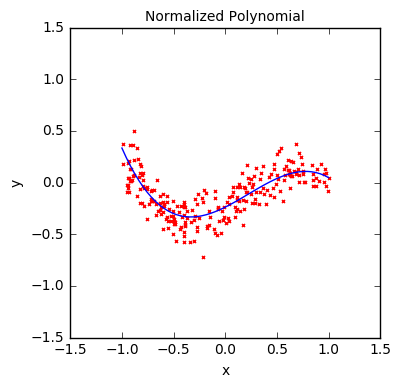

In [10]:
# plot points and polynomial curve

plt.close('all')
plt.figure(figsize=(4,4))
plt.title('Normalized Polynomial', fontsize='medium')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(xpoly,ypolyt, color = pltC[1])
plt.scatter(x,y, color = pltC[0], marker = pltM[1], s=5)
plt.axis(range=1, aspect=1)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.show()

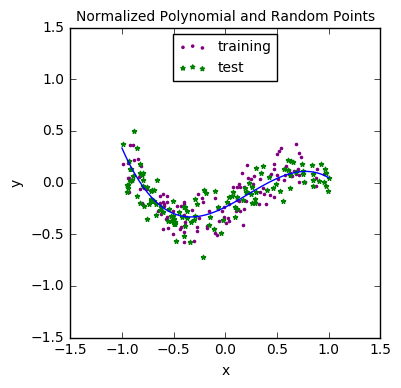

In [11]:
# plot points and curve

plt.close('all')
plt.figure(figsize=(4,4))
plt.title('Normalized Polynomial and Random Points', fontsize='medium')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(xpoly,ypolyt, color = pltC[1])
plt.scatter(x_train,y_train, color = pltC[3], marker = pltM[3], label='training', s=10)
plt.scatter(x_test,y_test, color = pltC[2], marker = pltM[2], label ='test', s=10)
plt.legend(loc='upper center', fontsize='medium')
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
# plt.axis(range=1, aspect=1)
plt.show()

In [12]:
class PolyFit(object):
    """ Polynomial Fit to a curve

    Parameters
    ------------
    eta : float
        Fitting rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    lambda_reg   : regularization parameter (is set to 1.0 for reg_type = 0)
    reg_type: regularization type
        0: none
        1: L1
        2: L2
    
    Attributes
    -----------
    c : 1d-array
        Polynomial coefficeints.
    cost_hist : list
        root-mean-squared error in every epoch.
    grad_hist : list
        magnitude of the cost gradient in every epoch

    """
    def __init__(self, batchsize=1, eta=0.1, n_iter=500, lambda_reg=0.0, reg_type=0, reg_power=0):
        self.batchsize = batchsize
        self.eta = eta
        self.n_iter = n_iter
        self.lambda_reg = lambda_reg
        self.reg_type = reg_type
        self.reg_power = reg_power
        return(None)
    
    def fit(self, deg, x, y):
        """ Fit curve in batch mode

        Parameters
        ----------
        deg: degree of the polynomial [integer]
        x : {array-like}, shape = [n_samples]
            x values of the curve
        y : {array-like}, shape = [n_samples]
            y values of the curve       
        
        Returns
        -------
        self : object

        """
        
        n_val = len(x)
        self.deg = deg
        self.deg1 = deg + 1
        self.c = np.zeros(deg+1)
        self.cost_hist = []
        self.grad_hist = []
        xbatch = np.zeros(n_val)
        ybatch = np.zeros(n_val)
        
        for n in range(self.n_iter):
            g = self.g(x)
            errors = (y - g)            
                        
            # create a batch
            if (self.batchsize >= n_val):
                # use all values
                xbatch = x
                ybatch = y          
            else:
                # use self.batchsize values
                s = np.arange(0,n_val)
                np.random.shuffle(s)
                xbatch = x[s[:self.batchsize]]
                ybatch = y[s[:self.batchsize]]
            # calculate gradient for batch and update the coefficients   
            gradient = self.gradcost(xbatch, ybatch)
            self.c -= self.eta * gradient
            cost = (errors**2).sum() 
            rmscost = np.sqrt(cost/n_val)
            self.cost_hist.append(rmscost)
            gradmag = np.sqrt(np.dot(gradient,gradient))    
            self.grad_hist.append(gradmag)
        return self
    
    def g(self, x):
        """ returns g values for given x values """
        nval = len(x)
        g_val = np.zeros(nval)
        for j in range(0, nval):
            g_val[j] = self.c[0]
            for k in range(1, self.deg1):
                g_val[j] +=  self.c[k] * x[j]**k  
        return (g_val)
    
    def cost(self, x, y):
        """ return cost cost function for a given x, y """
        n_val = len(x)
        cost_val = (0.5 / n_val) *  ((y - g(x))**2).sum()
        if (self.reg_type == 2):
            for j in range (1, self.deg1):
                cost_val += (j**self.reg_power) * 0.5 * self.lambda_reg * self.c[j]**2 
        elif(self.reg_type == 1):
            for j in range (1, self.deg1):
                cost_val += (j**self.reg_power) * 0.5 * self.lambda_reg * abs(self.c[j])
        return(cost_val)
        
    def gradcost(self, x, y):
        """ returns the gradient for a sample of given x values """
        n_val = len(x)
        self.grad = np.zeros(self.deg1) 
        for m in range(0, self.deg1):                              
            self.grad[m] = - (1/n_val) * ((y - self.g(x))*x**m).sum()
            if (m > 0):
                if (self.reg_type == 2):
                    self.grad[m] += self.lambda_reg * self.c[m] *t * m**self.reg_power
                elif (self.reg_type == 1):
                    self.grad[m] += self.lambda_reg * m**self.reg_power
        return(self.grad)
    
    def gerr(self, x, y):
        """ return the root-mean-squared error of given x and and y values """
        n_val = len(x)             
        perr = y - self.g(x)  
        rmserr = np.sqrt((perr**2).sum()/n_val) 
        return (rmserr)
    
    def getcoef(self):
        """ get the coefficents """
        return(self.c)
    
    def setcoef(self,coef):
        """ set the coefficients """ 
        self.c = coef
        return 

In [45]:
# fit training data for a variety of polynoical degrees
def curve_fitting_poly(whatreg, whatlambda, whatpower):
    global table_information
    
    ndegrees = 7
    ndegrees1 = ndegrees+1
    degrees = np.arange(0,ndegrees1)
    err_train = np.zeros(ndegrees1)
    err_test = np.zeros(ndegrees1)
    xxx = np.linspace(-1.0, 1.0,50)
    yyyi = np.zeros((50,ndegrees1))
    yyye = np.zeros((50,ndegrees1))
    cffit = np.zeros((ndegrees1))

    # assume ndegrees > coefs 
    cfinp = np.zeros(ndegrees1)
    for i in range(0,ncoefs):
        cfinp[i] = cf[i]
    for i in range(ncoefs+1,ndegrees1):
        cfinp[i] = 0    

    barwidth = 0.4
    xbarinp = np.zeros(ndegrees1)
    xbarfit = np.zeros(ndegrees1)
    for i in range(0,ndegrees1):
        xbarinp[i] = i - barwidth/2
        xbarfit[i] = i + barwidth/2   
    # set parameters

    nbatchsize = 1000
    niters = 250
    Eta = 0.5
    Lvalue = whatlambda
    RType = whatreg
    power = whatpower
    costi = np.zeros((niters,ndegrees1))
    gradi = np.zeros((niters,ndegrees1))
    
    for i in range (0, ndegrees1):

#         print('degree:         ', degrees[i])
#         print('sample size:    ', ntrain)
#         print('parameters:     ', degrees[i]+1)
#         print('iterations:     ', niters)
#         print('batch size:     ', nbatchsize)
#         print('eta:            ', Eta )
#         print('lambda          ', Lvalue)
#         print('Regularization: ', RType)
#         print('inner loop:     ', min(nbatchsize,ntrain)*(degrees[i]+1)*niters)
#         print('Power: ', power)

        PF = PolyFit(batchsize=nbatchsize, eta=Eta, n_iter=niters, lambda_reg=Lvalue, reg_type=RType, reg_power=power)
        PF.fit(degrees[i], x_train, y_train)
        gerr = PF.gerr(x_train, y_train)
        perr = PF.gerr(x_test, y_test)
        err_train[i] = gerr
        err_test[i] = perr  
        yyyi[:,i] = PF.g(xxx)
        yyye[:,i] = yyyi[:,i] - ypolyt[:] 
        costi[:,i] = PF.cost_hist[:]
        gradi[:,i] = PF.grad_hist[:]
        table_information.append([RType, Lvalue, power, Eta, niters, min(nbatchsize,ntrain)*(degrees[i]+1)*niters, gerr, perr])
#         print('train rms error:', gerr)
#         print('test rms error: ', perr)

    # plot coefficients
        for j in range(0,ndegrees1):
            if (j <= degrees[i]):
                cffit[j] = PF.c[j]           
#         plt.close('all')
#         fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (8,4))
#         ax.bar(xbarinp, cfinp, barwidth, color = 'red', align='center', label='Input')
#         ax.bar(xbarfit, cffit, barwidth, color = 'blue', align='center', label='Fit')
#         ax.set_xlabel('i')
#         ax.set_ylabel('Coefficient')
#         ax.legend(loc='upper right', fontsize='medium')
#         ax.set_title('Scaled Polynomial Coefficients', fontsize ='medium')
#         plt.show()   
#     # plot rms error by epoch   
#         plt.close('all')
#         fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (8,4))
#         ax[0].set_xlabel('epoch')
#         ax[0].set_ylabel('rms error')
#         ax[0].set_title('RMS Error', fontsize ='medium')
#         ax[0].plot(range(1, niters + 1),costi[:,i])
#         ax[1].set_xlabel('epoch')
#         ax[1].set_ylabel('rms error')
#         ax[1].set_title('RMS Error', fontsize ='medium')
#         ax[1].semilogy(range(1, niters + 1),costi[:,i])
#         plt.show()
#     # plot ||gradient|| by epoch
#         plt.close('all')
#         fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (8,4))
#         ax[0].set_xlabel('epoch')
#         ax[0].set_ylabel('||gradient||')
#         ax[0].set_title('Gradient', fontsize ='medium')
#         ax[0].plot(range(1, niters + 1),gradi[:,i])
#         ax[1].set_xlabel('epoch')
#         ax[1].set_ylabel('||gradient||')
#         ax[1].set_title('Gradient', fontsize ='medium')
#         ax[1].semilogy(range(1, niters + 1),gradi[:,i])
#         plt.show()

#         print(' ')
#     print ('done')
#     rest(ndegrees, xxx, yyyi, yyye, ndegrees1, niters, costi, gradi, err_test, err_train)

In [22]:
def rest(ndegrees, xxx, yyyi, yyye, ndegrees1, niters, costi, gradi, err_test, err_train):
    # plot the results
    global x_train, y_train_, pltC, pltM, x_test, y_test, xpoly, ypolyt
    plt.close('all')
    plt.figure(figsize=(8, 8))
    plt.title('Fit Curves', fontsize='medium')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.scatter(x_train,y_train, color = pltC[3], marker = pltM[3], label='training')
    plt.scatter(x_test,y_test, color = pltC[2], marker = pltM[2], label ='test', s=20)
    plt.plot(xpoly,ypolyt, color = pltC[1], label='source')
    for i in range(0, ndegrees):
        plt.plot(xxx,yyyi[:,i], label=degrees[i])
    plt.legend(loc='center left', fontsize='small')
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    plt.axis(range=1, aspect=1)
    plt.show()

    # plot the results without the input sample

    plt.close('all')
    plt.figure(figsize=(8, 8))
    plt.title('Fit Curves', fontsize='medium')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.plot(xpoly,ypolyt, color = pltC[1], label='source')
    for i in range(0, ndegrees):
        plt.plot(xxx,yyyi[:,i], label=degrees[i])
    plt.legend(loc='center left', fontsize='small')
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    plt.axis(range=1, aspect=1)
    plt.show()

    # plot the errors

    plt.close('all')
    plt.figure(figsize=(8, 8))
    plt.title('Errors', fontsize='medium')
    plt.xlabel('x')
    plt.ylabel('y')
    #plt.scatter(x_train,y_train, color = pltC[3], marker = pltM[3], label='training')
    #plt.scatter(x_test,y_test, color = pltC[2], marker = pltM[2], label ='test', s=20)
    #plt.plot(xpoly,ypolyt, color = pltC[1], label='source')
    for i in range(0, ndegrees):
        plt.plot(xxx,yyye[:,i], label=degrees[i])
    plt.legend(loc='center left', fontsize='small')
    plt.xlim(-1.5,1.5)
    #plt.ylim(-1.5,1.5)
    plt.axis(range=1, aspect=1)
    plt.show()

    # plot the errors in more detail

    plt.close('all')
    plt.figure(figsize=(8, 8))
    plt.title('Errors', fontsize='medium')
    plt.xlabel('x')
    plt.ylabel('y')
    #plt.scatter(x_train,y_train, color = pltC[3], marker = pltM[3], label='training')
    #plt.scatter(x_test,y_test, color = pltC[2], marker = pltM[2], label ='test', s=20)
    #plt.plot(xpoly,ypolyt, color = pltC[1], label='source')
    for i in range(0, ndegrees):
        plt.plot(xxx,yyye[:,i], label=degrees[i])
    plt.legend(loc='center left', fontsize='small')
    plt.xlim(-1.5,1.5)
    plt.ylim(-0.1,0.1)
    plt.axis(range=1, aspect=1)
    plt.show()

    #plot rms error
    plt.close('all')

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (8,8))
    for i in range(0,ndegrees1):
        ax[0].plot(range(1, niters + 1),costi[:,i], label=degrees[i])
        ax[1].semilogy(range(1, niters + 1),costi[:,i], label=degrees[i])
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('rms error')
    ax[0].set_title('Convergence', fontsize ='medium')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('rms error')
    ax[1].set_title('Convergence', fontsize ='medium')
    ax[1].legend(loc='lower left', fontsize='small')
    plt.show()

    #plot ||gradient||
    plt.close('all')

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (8,8))
    for i in range(0,ndegrees1):
        ax[0].plot(range(1, niters + 1),gradi[:,i], label=degrees[i])
        ax[1].semilogy(range(1, niters + 1),gradi[:,i], label=degrees[i])
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('||gradient||')
    ax[0].set_title('Gradient', fontsize ='medium')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('||gradient||')
    ax[1].set_title('Gradient', fontsize ='medium')
    ax[1].legend(loc='lower left', fontsize='small')
    plt.show()

    # plot training and test errors

    plt.close('all')
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (8,4))
    ax.plot(degrees, err_train, color='blue', label='train')
    ax.plot(degrees, err_test, color='red', label='test')
    ax.set_xlabel('Polynomial Degree')
    ax.set_ylabel('RMS Error')
    ax.legend(loc='upper right', fontsize='medium')
    ax.set_title('Training & Test Error', fontsize ='medium')
    plt.show()

In [46]:
table_information = []
curve_fitting_poly(0, 0, 0)
for a in range(1,3):
    reg = a
    for b in [0, 10, 100]:
        lam = b
        for c in [0,1]:
            power = c
            curve_fitting_poly(reg, lam, power)

In [49]:
from tabulate import tabulate

print(tabulate(table_information, headers=["RType", "LValue", "Power", "Learning Rate", "Iteration", "Loop"  ,"Train rms error", "Test rms error"]))

# table_information

  RType    LValue    Power    Learning Rate    Iteration    Loop    Train rms error    Test rms error
-------  --------  -------  ---------------  -----------  ------  -----------------  ----------------
      0         0        0              0.5          250   31250       0.227372          0.209744
      0         0        0              0.5          250   62500       0.215596          0.205959
      0         0        0              0.5          250   93750       0.16036           0.182504
      0         0        0              0.5          250  125000       0.129921          0.131076
      0         0        0              0.5          250  156250       0.131582          0.133293
      0         0        0              0.5          250  187500       0.131955          0.131721
      0         0        0              0.5          250  218750       0.131165          0.130574
      0         0        0              0.5          250  250000       0.132277          0.131944
      1     